In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import MeCab
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

In [2]:
# GPU 메모리 최적화
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
# 파일 로드
path = '~/aiffel/dktc/data_forder/gpt_result.csv'
data = pd.read_csv(path)

In [4]:
# MeCab 형태소 분석기 초기화
mecab = MeCab.Tagger()

In [5]:
# MeCab의 parse 결과를 파싱하여 (word, pos) 튜플의 리스트로 변환하는 함수
def parse_mecab_output(text):
    parsed = mecab.parse(text)
    parsed_lines = parsed.strip().split('\n')
    tokens = []
    for line in parsed_lines:
        if line == 'EOS':
            break
        else:
            try:
                surface, feature = line.split('\t')
                pos = feature.split(',')[0]
                tokens.append((surface, pos))
            except ValueError:
                continue  # 빈 줄이나 형식에 맞지 않는 줄은 무시
    return tokens

# 추가된 전처리 함수들
def remove_urls_emails(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\S+@\S+', '', text)
    return text


In [6]:
# 전처리 및 형태소 분석 클래스 정의
class TextPreprocessor:
    def __init__(self, pos_to_keep=None):
        if pos_to_keep is None:
            self.pos_to_keep = [
                'NNG', 'NNP', 'NNB', 'NNBC', 'NR', 'NP', 'VV', 'VA', 'VX',
                'VCP', 'VCN', 'MM', 'MAG', 'MAJ', 'XR', 'IC', 'JKS', 'JKC',
                'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC', 'EP', 'EF',
                'EC', 'ETN', 'ETM', 'XPN', 'XSN', 'XSV', 'XSA', 'SN', 'SL',
                'SH', 'SY'
            ]
        else:
            self.pos_to_keep = pos_to_keep

    def normalize_text(self, text):
        text = remove_urls_emails(text)
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # 반복 문자 줄이기
        text = re.sub(r'\s+', ' ', text)             # 다중 공백 제거
        text = text.strip()                          # 앞뒤 공백 제거
        return text

    def filter_by_pos(self, sentence):
        parsed_sentence = parse_mecab_output(sentence)
        filtered_tokens = [word for word, pos in parsed_sentence if pos in self.pos_to_keep]
        return filtered_tokens

    def preprocess_and_tokenize(self, sentence):
        if pd.isnull(sentence):
            return []
        sentence = self.normalize_text(sentence)
        tokens = self.filter_by_pos(sentence)
        return tokens

    def apply_to_dataframe(self, df, column_name):
        df[column_name] = df['conversation'].apply(self.preprocess_and_tokenize)
        return df

In [7]:
# 전처리 클래스 인스턴스 생성
preprocessor = TextPreprocessor()

# 데이터프레임 복사
df = data.copy()

# 전처리 및 토큰화 적용
df = preprocessor.apply_to_dataframe(df, 'preprocess_conversation')

# 토큰 리스트를 문자열로 변환하여 'processed_text' 컬럼 생성
df['processed_text'] = df['preprocess_conversation'].apply(lambda tokens: ' '.join(tokens))

In [8]:
# 레이블 인코딩
label_encoding = {
    '협박 대화': 0,
    '기타 괴롭힘 대화': 1,
    '갈취 대화': 2,
    '직장 내 괴롭힘 대화': 3,
    '일반대화' : 4
}
df['class'] = df['class'].map(label_encoding)

In [9]:
from transformers import BertTokenizer, TFBertModel

# 사전 훈련된 한국어 BERT 모델과 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('kykim/bert-kor-base')
bert_model = TFBertModel.from_pretrained('kykim/bert-kor-base')


All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at kykim/bert-kor-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


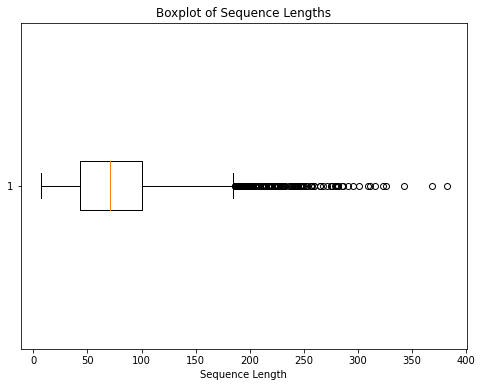

In [10]:
# 시퀀스 길이 박스플롯을 위해 패딩 전에 시퀀스 길이 계산
sequence_lengths = df['preprocess_conversation'].apply(len).tolist()

plt.figure(figsize=(8, 6))
plt.boxplot(sequence_lengths, vert=False)
plt.title('Boxplot of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.show()

In [11]:
# 토큰화 함수 정의 (패딩 전에 시퀀스 길이 확인 완료)
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts.tolist(),
        padding='max_length',  # 시퀀스를 max_length로 패딩
        truncation=True,       # max_length를 초과하는 시퀀스는 자름
        max_length=max_length,
        return_tensors='tf'    # 텐서 형식으로 반환
    )

In [12]:
# 최대 시퀀스 길이 결정
max_seq_len = 200  # 메모리 부족 문제 해결을 위해 시퀀스 길이 줄이기

In [13]:
# 토큰화 수행: 'processed_text' 컬럼 사용
tokenized_data = tokenize_texts(df['processed_text'], tokenizer, max_seq_len)

input_ids = tokenized_data['input_ids']
attention_mask = tokenized_data['attention_mask']

# 레이블 준비
y = df['class'].values

In [14]:
from sklearn.model_selection import train_test_split

# input_ids와 attention_mask를 넘파이 배열로 변환 (이전 코드의 부분)
input_ids_np = input_ids.numpy()
attention_mask_np = attention_mask.numpy()

# 학습과 검증 데이터를 8:2로 나눔 (클래스 비율 유지)
X_train_input_ids, X_val_input_ids, X_train_attention_mask, X_val_attention_mask, y_train, y_val = train_test_split(
    input_ids_np,       # input_ids
    attention_mask_np,  # attention_mask
    y,                  # target (class labels)
    test_size=0.2,      # 검증 데이터 비율 20%
    random_state=100,   # 시드 고정
    stratify=y          # 클래스 비율 유지
)

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense

def build_classification_model(max_seq_len, num_classes):
    # 입력 레이어 정의
    input_ids = Input(shape=(max_seq_len,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(max_seq_len,), dtype=tf.int32, name="attention_mask")
    
    # BERT 모델을 통해 임베딩 획득
    bert_outputs = bert_model(input_ids, attention_mask=attention_mask)
    pooled_output = bert_outputs.pooler_output  # [CLS] 토큰의 출력
    
    # 드롭아웃 레이어
    dropout = Dropout(0.3)(pooled_output)
    
    # 출력 레이어
    outputs = Dense(num_classes, activation='softmax')(dropout)
    
    # 모델 정의
    model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
    
    return model

In [16]:
# 클래스 수 설정
num_classes = 5  # 필요에 따라 조정

# 모델 생성
model = build_classification_model(max_seq_len, num_classes)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 요약 확인
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 200)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 118297344   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           tf_bert_model[0][1]          

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# 체크포인트 저장 디렉토리 생성
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 조기 종료 및 모델 체크포인트 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best_model.h5'),  # 체크포인트 저장 경로
    monitor='val_loss',                                      # 모니터링할 지표
    save_best_only=True,                                     # 최상의 모델만 저장
    save_weights_only=True,                                  # 가중치만 저장
    verbose=1                                                # 저장 시 메시지 출력
)

# 추가적인 학습률 스케줄러 (선택 사항)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# 콜백 리스트에 추가
callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [18]:
# 모델 학습
history = model.fit(
    [X_train_input_ids, X_train_attention_mask],
    y_train,
    validation_data=([X_val_input_ids, X_val_attention_mask], y_val),
    epochs=10,
    batch_size=16, 
    callbacks=callbacks
)

Epoch 1/10
247/247 [==============================] - 196s 739ms/step - loss: 0.5833 - accuracy: 0.7884 - val_loss: 0.4170 - val_accuracy: 0.8580

Epoch 00001: val_loss improved from inf to 0.41699, saving model to checkpoints/best_model.h5
Epoch 2/10
247/247 [==============================] - 181s 733ms/step - loss: 0.2717 - accuracy: 0.9104 - val_loss: 0.4266 - val_accuracy: 0.8470

Epoch 00002: val_loss did not improve from 0.41699
Epoch 3/10
247/247 [==============================] - 181s 732ms/step - loss: 0.1603 - accuracy: 0.9511 - val_loss: 0.3027 - val_accuracy: 0.9040

Epoch 00003: val_loss improved from 0.41699 to 0.30273, saving model to checkpoints/best_model.h5
Epoch 4/10
247/247 [==============================] - 181s 733ms/step - loss: 0.1020 - accuracy: 0.9671 - val_loss: 0.2857 - val_accuracy: 0.9220

Epoch 00004: val_loss improved from 0.30273 to 0.28567, saving model to checkpoints/best_model.h5
Epoch 5/10
247/247 [==============================] - 181s 733ms/step -

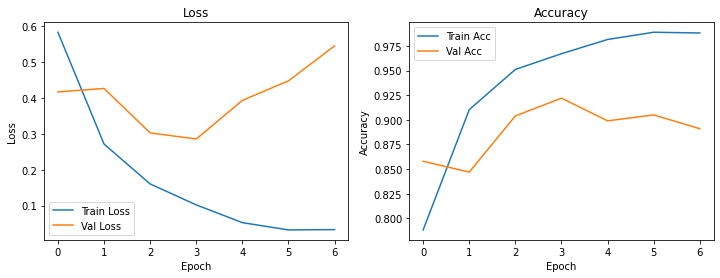

In [19]:
# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
# 검증 데이터에 대한 예측 및 분류 보고서
y_pred = model.predict([X_val_input_ids, X_val_attention_mask])
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_val, y_pred_classes, target_names=label_encoding.keys(), output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
report_df = report_df.round(4)
report_df

,precision,recall,f1-score,support
협박 대화,0.8565,0.895,0.8753,200.000
기타 괴롭힘 대화,0.9005,0.860,0.8798,200.000
갈취 대화,0.8800,0.880,0.8800,200.000
직장 내 괴롭힘 대화,0.9750,0.975,0.9750,200.000
일반대화,1.0000,1.000,1.0000,200.000
accuracy,0.9220,0.922,0.9220,0.922
macro avg,0.9224,0.922,0.9220,1000.000
weighted avg,0.9224,0.922,0.9220,1000.000


In [22]:
from tensorflow.keras.models import load_model

# 저장된 모델의 가중치를 불러오는 경로 설정
model_path = os.path.join('checkpoints', 'best_model.h5')

In [23]:
# 레이블 매핑 (번호 -> 텍스트)
label_mapping = {
    0: '협박 대화',
    1: '기타 괴롭힘 대화',
    2: '갈취 대화',
    3: '직장 내 괴롭힘 대화',
    4: '일반 대화'
}

In [24]:
# 1. 저장된 모델 불러오기
model.load_weights(model_path)

In [25]:
# 2. 테스트 데이터 로드
test_data_path = '~/aiffel/dktc/data_forder/test.csv'
test_df = pd.read_csv(test_data_path)

In [26]:
# 3. 테스트 데이터 전처리 (훈련 데이터와 동일한 방식으로)
test_df['preprocess_conversation'] = test_df['text'].apply(preprocessor.preprocess_and_tokenize)
test_df['processed_text'] = test_df['preprocess_conversation'].apply(lambda tokens: ' '.join(tokens))


In [27]:
# 4. 토큰화된 테스트 데이터 생성
tokenized_test_data = tokenize_texts(test_df['processed_text'], tokenizer, max_seq_len)
input_ids_test = tokenized_test_data['input_ids']
attention_mask_test = tokenized_test_data['attention_mask']

In [114]:
# 5. 모델로 예측 수행
y_test_pred = model.predict([input_ids_test, attention_mask_test])

In [115]:
# 6. 예측 클래스 추출
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

In [122]:
# Threshold 값 설정
threshold = 0.2

In [123]:
# 7. 일반 대화에 대한 threshold 적용
# 각 클래스의 확률에서 일반 대화의 확률(y_test_pred[:, 4])이 threshold 이상일 때, '일반 대화'로 강제 분류
for i in range(len(y_test_pred)):
    general_conversation_prob = y_test_pred[i, 4]  # 일반 대화의 확률
    if general_conversation_prob >= threshold:
        y_test_pred_classes[i] = 4  # 일반 대화로 분류
        
# 예측 클래스 값 확인 (디버깅용)
print("예측 클래스 값 (threshold 적용 후):", y_test_pred_classes)

예측 클래스 값 (threshold 적용 후): [2 3 3 1 1 0 0 1 1 2 0 1 3 3 3 2 1 1 0 1 0 1 1 2 2 3 1 1 3 1 2 0 1 2 0 1 1
 0 0 2 0 2 3 2 1 3 0 1 1 0 2 1 2 3 3 1 1 1 1 1 2 0 3 1 3 0 1 1 0 2 0 3 1 3
 0 3 3 2 3 1 2 0 0 0 1 3 0 1 2 3 3 3 0 1 1 3 2 3 0 0 2 2 1 0 3 3 3 1 1 0 0
 0 0 3 2 2 2 3 3 2 3 1 1 2 2 2 3 2 2 1 1 1 3 1 2 0 1 0 1 3 0 1 2 1 3 0 0 0
 0 2 0 1 0 2 3 1 0 3 1 1 0 1 3 0 3 1 3 1 1 2 0 3 3 1 1 1 0 3 2 2 3 1 2 3 0
 1 3 0 2 0 0 1 2 1 2 1 0 3 1 0 3 0 1 1 0 1 3 2 3 3 1 1 0 3 2 1 1 0 0 0 2 3
 0 1 0 2 2 0 2 0 3 0 0 1 2 1 1 2 2 1 1 1 1 3 1 2 3 1 3 0 0 1 0 3 3 2 1 3 2
 3 2 0 2 1 3 1 1 1 1 1 0 1 0 3 2 3 3 1 3 3 2 0 1 3 3 3 2 3 2 1 2 2 1 1 3 1
 1 1 0 0 3 1 0 3 2 2 1 3 2 3 2 2 1 1 3 1 0 1 1 0 3 0 0 1 2 2 1 2 3 1 1 0 0
 1 2 1 1 2 4 1 0 3 0 0 2 3 1 2 0 0 0 1 2 2 2 1 1 1 0 2 1 0 2 2 3 1 2 3 0 0
 3 3 0 3 3 2 2 0 2 2 3 0 3 3 1 2 1 0 0 1 2 0 2 3 2 1 0 1 0 0 1 2 3 3 1 0 3
 2 3 0 0 1 0 3 3 3 1 2 0 0 2 0 0 1 1 2 0 3 3 0 1 1 2 0 2 1 0 1 1 3 1 0 3 2
 2 3 0 3 3 1 2 0 3 1 3 1 3 1 2 0 0 2 2 3 3 2 1 3 1 0 3 2 0 1 1 3 2 2 1 3 

In [124]:
# 8. 예측 클래스 번호를 텍스트 레이블로 변환
test_df['class'] = y_test_pred_classes
test_df['class'] = test_df['class'].map(label_mapping)


In [125]:
# 9. 제출 파일 작성
submission = test_df[['idx', 'class']]
submission.columns = ['file_name', 'class']
submission.to_csv('~/aiffel/dktc/data_forder/submission.csv', index=False)

In [126]:
test_df['class'].unique()

array(['갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '협박 대화', '일반 대화'],
      dtype=object)

In [127]:
test_df['class'].value_counts()

기타 괴롭힘 대화      152
협박 대화          122
직장 내 괴롭힘 대화    116
갈취 대화          109
일반 대화            1
Name: class, dtype: int64